# Acrobot-v1 with Q-Learning and Tile Coding
---

Q-Learning is implemented based on the paper: <br/>
*Watkins, C.J.C.H. & Dayan, P. Mach Learn (1992) 8: 279. https://doi.org/10.1007/BF00992698*

Tile Coding is explained further in the textbook:<br/> 
*Sutton, R. S., and Barto, A. G. 1998. Reinforcement Learning: An Introduction (Adaptive Computation and Machine
Learning). The MIT Press.*

More about `Acrobot-v1` OpenAI Gym envrionment is found at: https://gym.openai.com/envs/Acrobot-v1/

An interesting paper that explores using Q-Learning with Tile Coding is cited below. The authors' findings help to understand the results of this file's solution to Acrobot-v1:<br/>
*Sherstov, Alexander A. and Peter Stone. “On Continuous-Action Q-Learning via Tile Coding Function Approximation.” (2004).*

In [103]:
# Import common libraries
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

# Create an environment
env = gym.make('Acrobot-v1')
env.seed(505);

In [105]:
def create_tiling_grid(low, high, bins=(10, 10), offsets=(0.0, 0.0)):
    """Define a uniformly-spaced grid that can be used for tile-coding a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins or tiles along each corresponding dimension.
    offsets : tuple
        Split points for each dimension should be offset by these values.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] + offsets[dim] for dim in range(len(bins))]
    print("Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>")
    for l, h, b, o, splits in zip(low, high, bins, offsets, grid):
        print("    [{}, {}] / {} + ({}) => {}".format(l, h, b, o, splits))
    return grid


low = [-1.0, -5.0]
high = [1.0, 5.0]
create_tiling_grid(low, high, bins=(10, 10), offsets=(-0.1, 0.5))  # [test]

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (-0.1) => [-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7]
    [-5.0, 5.0] / 10 + (0.5) => [-3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]


[array([-0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7]),
 array([-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5])]

In [106]:
def create_tilings(low, high, tiling_specs):
    """Define multiple tilings using the provided specifications.

    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    tiling_specs : list of tuples
        A sequence of (bins, offsets) to be passed to create_tiling_grid().

    Returns
    -------
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    """
    return [create_tiling_grid(low, high, bins, offsets) for bins, offsets in tiling_specs]


# Tiling specs: [(<bins>, <offsets>), ...]
tiling_specs = [((10, 10), (-0.066, -0.33)),
                ((10, 10), (0.0, 0.0)),
                ((10, 10), (0.066, 0.33))]
tilings = create_tilings(low, high, tiling_specs)

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (-0.066) => [-0.866 -0.666 -0.466 -0.266 -0.066  0.134  0.334  0.534  0.734]
    [-5.0, 5.0] / 10 + (-0.33) => [-4.33 -3.33 -2.33 -1.33 -0.33  0.67  1.67  2.67  3.67]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.0) => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 + (0.0) => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.066) => [-0.734 -0.534 -0.334 -0.134  0.066  0.266  0.466  0.666  0.866]
    [-5.0, 5.0] / 10 + (0.33) => [-3.67 -2.67 -1.67 -0.67  0.33  1.33  2.33  3.33  4.33]


In [108]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    return tuple(int(np.digitize(s, g)) for s, g in zip(sample, grid))


def tile_encode(sample, tilings, flatten=False):
    """Encode given sample using tile-coding.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    flatten : bool
        If true, flatten the resulting binary arrays into a single long vector.

    Returns
    -------
    encoded_sample : list or array_like
        A list of binary vectors, one for each tiling, or flattened into one.
    """
    encoded_sample = [discretize(sample, grid) for grid in tilings]
    if flatten:
        return np.asarray(encoded_sample).flatten()
    else:
        return encoded_sample

# Test with some sample values
samples = [(-1.2 , -5.1 ),
           (-0.75,  3.25),
           (-0.5 ,  0.0 ),
           ( 0.25, -1.9 ),
           ( 0.15, -1.75),
           ( 0.75,  2.5 ),
           ( 0.7 , -3.7 ),
           ( 1.0 ,  5.0 )]
encoded_samples = [tile_encode(sample, tilings) for sample in samples]
print("\nSamples:", repr(samples), sep="\n")
print("\nEncoded samples:", repr(encoded_samples), sep="\n")


Samples:
[(-1.2, -5.1), (-0.75, 3.25), (-0.5, 0.0), (0.25, -1.9), (0.15, -1.75), (0.75, 2.5), (0.7, -3.7), (1.0, 5.0)]

Encoded samples:
[[(0, 0), (0, 0), (0, 0)], [(1, 8), (1, 8), (0, 7)], [(2, 5), (2, 5), (2, 4)], [(6, 3), (6, 3), (5, 2)], [(6, 3), (5, 3), (5, 2)], [(9, 7), (8, 7), (8, 7)], [(8, 1), (8, 1), (8, 0)], [(9, 9), (9, 9), (9, 9)]]


In [110]:
class QTable:
    """Simple Q-table."""

    def __init__(self, state_size, action_size):
        """Initialize Q-table.
        
        Parameters
        ----------
        state_size : tuple
            Number of discrete values along each dimension of state space.
        action_size : int
            Number of discrete actions in action space.
        """
        self.state_size = state_size
        self.action_size = action_size
        
        # Create Q-table, initialize all Q-values to zero
        # Note: If state_size = (9, 9), action_size = 2, q_table.shape should be (9, 9, 2)
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("QTable(): size =", self.q_table.shape)


class TiledQTable:
    """Composite Q-table with an internal tile coding scheme."""
    
    def __init__(self, low, high, tiling_specs, action_size):
        """Create tilings and initialize internal Q-table(s).
        
        Parameters
        ----------
        low : array_like
            Lower bounds for each dimension of state space.
        high : array_like
            Upper bounds for each dimension of state space.
        tiling_specs : list of tuples
            A sequence of (bins, offsets) to be passed to create_tilings() along with low, high.
        action_size : int
            Number of discrete actions in action space.
        """
        self.tilings = create_tilings(low, high, tiling_specs)
        self.state_sizes = [tuple(len(splits)+1 for splits in tiling_grid) for tiling_grid in self.tilings]
        self.action_size = action_size
        self.q_tables = [QTable(state_size, self.action_size) for state_size in self.state_sizes]
        print("TiledQTable(): no. of internal tables = ", len(self.q_tables))
    
    def get(self, state, action):
        """Get Q-value for given <state, action> pair.
        
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        
        Returns
        -------
        value : float
            Q-value of given <state, action> pair, averaged from all internal Q-tables.
        """
        # Encode state to get tile indices
        encoded_states = tile_encode(state, self.tilings)

        # Retrieve q-value for each tiling, and return their average
        q_value = 0.0
        for (encoded_state, q_table) in zip(encoded_states, self.q_tables):
            q_value += q_table.q_table[tuple(encoded_state + (action,))]
        q_value /= len(encoded_states)
        return q_value
    
    def get_greedy_action(self, state):
        """Given a state, choose the best action based on the greedy policy approach.
        
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        
        Returns
        -------
        value : greedy_action
            The best action index with the maximum Q value for the given state.
        """
        greedy_action = 0
        max_val = self.get(state, greedy_action)
        for action in range(self.action_size):
            val = self.get(state, action)
            if max_val < val:
                max_val = val
                greedy_action = action
        return greedy_action

    def update(self, state, action, value, alpha=0.1):
        """Soft-update Q-value for given <state, action> pair to value.
        
        Instead of overwriting Q(state, action) with value, perform soft-update:
            Q(state, action) = alpha * value + (1.0 - alpha) * Q(state, action)
        
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        value : float
            Desired Q-value for <state, action> pair.
        alpha : float
            Update factor to perform soft-update, in [0.0, 1.0] range.
        """
        # Encode state to get tile indices
        encoded_states = tile_encode(state, self.tilings)

        # Update q-value for each tiling by update factor alpha
        for (encoded_state, q_table) in zip(encoded_states, self.q_tables):
            q_0 = q_table.q_table[tuple(encoded_state + (action,))]
            q_table.q_table[tuple(encoded_state + (action,))] = q_0 * (1.0 - alpha) + alpha * value


# Test with a sample Q-table
tq = TiledQTable(low, high, tiling_specs, 2)
s1 = 3; s2 = 4; a = 0; q = 1.0
print("[GET]    Q({}, {}) = {}".format(samples[s1], a, tq.get(samples[s1], a)))  # check value at sample = s1, action = a
print("[UPDATE] Q({}, {}) = {}".format(samples[s2], a, q)); tq.update(samples[s2], a, q)  # update value for sample with some common tile(s)
print("[GET]    Q({}, {}) = {}".format(samples[s1], a, tq.get(samples[s1], a)))  # check value again, should be slightly updated

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (-0.066) => [-0.866 -0.666 -0.466 -0.266 -0.066  0.134  0.334  0.534  0.734]
    [-5.0, 5.0] / 10 + (-0.33) => [-4.33 -3.33 -2.33 -1.33 -0.33  0.67  1.67  2.67  3.67]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.0) => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 + (0.0) => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.066) => [-0.734 -0.534 -0.334 -0.134  0.066  0.266  0.466  0.666  0.866]
    [-5.0, 5.0] / 10 + (0.33) => [-3.67 -2.67 -1.67 -0.67  0.33  1.33  2.33  3.33  4.33]
QTable(): size = (10, 10, 2)
QTable(): size = (10, 10, 2)
QTable(): size = (10, 10, 2)
TiledQTable(): no. of internal tables =  3
[GET]    Q((0.25, -1.9), 0) = 0.0
[UPDATE] Q((0.15, -1.75), 0) = 1.0
[GET]    Q((0.25, -1.9), 0) = 0.06666666666666667


In [115]:
class QLearningAgent:
    """Q-Learning agent that can act on a continuous state space by discretizing it."""

    def __init__(self, env, tiling_specs, alpha=0.02, gamma=0.9999,
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01, seed=505):
        """Initialize variables, create grid for discretization."""
        # Environment info
        self.env = env
        self.action_size = self.env.action_space.n  # 1-dimensional discrete action space
        self.seed = np.random.seed(seed)
        self.tiling_specs = tiling_specs
        self.low = env.observation_space.low
        self.high = env.observation_space.high
        print("Environment:", self.env)
        print("Action space size:", self.action_size)
        
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon
        
        # Create Q-table
        self.tiled_q_tables = TiledQTable(self.low, self.high, self.tiling_specs, self.action_size)

    def preprocess_state(self, state):
        """Map a continuous state to its discretized representation."""
        return state

    def reset_episode(self, state):
        """Reset variables for a new episode."""
        # Gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)

        # Decide initial action
        self.last_state = self.preprocess_state(state)
        self.last_action = self.tiled_q_tables.get_greedy_action(self.last_state)
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon

    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        state = self.preprocess_state(state)
        if mode == 'test':
            # Test mode: Simply produce an action
            action = self.tiled_q_tables.get_greedy_action(state)
        else:
            # Train mode (default): Update Q table, pick next action
            # Note: We update the Q table entry for the *last* (state, action) pair with current state, reward
            greedy_action = self.tiled_q_tables.get_greedy_action(state)
            value = reward + self.gamma * self.tiled_q_tables.get(state, greedy_action)
            self.tiled_q_tables.update(self.last_state, self.last_action, value, self.alpha)

            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the best action from Q table
                action = self.tiled_q_tables.get_greedy_action(state)

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action

n_bins = 8
bins = tuple([n_bins]*env.observation_space.shape[0])
offset_pos = (env.observation_space.high - env.observation_space.low)/(3*n_bins)

tiling_specs = [(bins, -offset_pos),
                (bins, tuple([0.0]*env.observation_space.shape[0])),
                (bins, offset_pos)]
    
q_agent = QLearningAgent(env, tiling_specs)

Environment: <TimeLimit<AcrobotEnv<Acrobot-v1>>>
Action space size: 3
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 8 + (-0.0833333358168602) => [-0.833 -0.583 -0.333 -0.083  0.167  0.417  0.667]
    [-1.0, 1.0] / 8 + (-0.0833333358168602) => [-0.833 -0.583 -0.333 -0.083  0.167  0.417  0.667]
    [-1.0, 1.0] / 8 + (-0.0833333358168602) => [-0.833 -0.583 -0.333 -0.083  0.167  0.417  0.667]
    [-1.0, 1.0] / 8 + (-0.0833333358168602) => [-0.833 -0.583 -0.333 -0.083  0.167  0.417  0.667]
    [-12.566370964050293, 12.566370964050293] / 8 + (-1.0471975803375244) => [-10.472  -7.33   -4.189  -1.047   2.094   5.236   8.378]
    [-28.274333953857422, 28.274333953857422] / 8 + (-2.356194496154785) => [-23.562 -16.493  -9.425  -2.356   4.712  11.781  18.85 ]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 8 + (0.0) => [-0.75 -0.5  -0.25  0.    0.25  0.5   0.75]
    [-1.0, 1.0] / 8 + (0.0) => [-0.75 -0.5  -0.25  0.    0.25  0.5   0.75]
   

In [116]:
def run(agent, env, num_episodes=10000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        # Initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False

        # Roll out steps until done
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(state, reward, done, mode)

        # Save final score
        scores.append(total_reward)
        
        # Print episode stats
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score

            if i_episode % 100 == 0:
                print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score),
                      end="")
                sys.stdout.flush()

    return scores

scores = run(q_agent, env)

Episode 10000/10000 | Max Average Score: -310.25

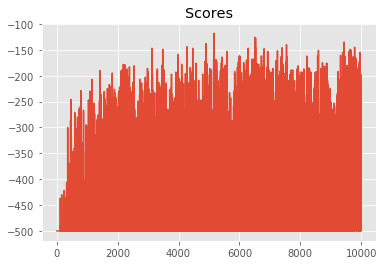

In [117]:
# Plot scores obtained per episode
plt.plot(scores); plt.title("Scores");

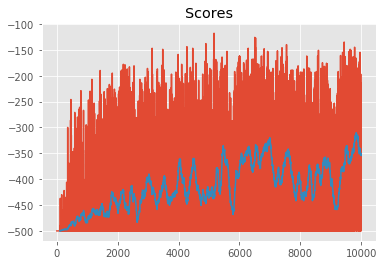

In [120]:
import pandas as pd
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores)

[TEST] Completed 100 episodes with avg. score = -412.57


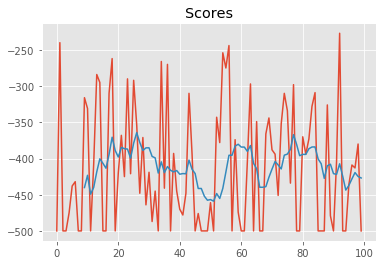

In [121]:
# Run in test mode and analyze scores obtained
test_scores = run(q_agent, env, num_episodes=100, mode='test')
print("[TEST] Completed {} episodes with avg. score = {}".format(len(test_scores), np.mean(test_scores)))
_ = plot_scores(test_scores, rolling_window=10)